In [273]:
import os
import math
import warnings

import cupy as cp
import pandas as pd
import numpy as np
import cudf

from cuml import PCA
from cuml import TSNE
from cuml import AgglomerativeClustering
from cuml.metrics.cluster.silhouette_score import cython_silhouette_score
from cuml.preprocessing import StandardScaler, RobustScaler, MinMaxScaler 
from cuml._thirdparty.sklearn.preprocessing import ColumnTransformer
from sklearn.base import clone
from cuml.pipeline import Pipeline
from sklearn.cluster import AgglomerativeClustering as sklearn_agg_cluster
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage, dendrogram
import optuna

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

cp.random.seed(27)
seed = 27
rs = np.random.RandomState(seed)

In [274]:
plt.rcParams['figure.figsize'] = (17, 14)

warnings.filterwarnings('ignore')

data_path = 'file:///content/drive/My Drive/Rapids/data_mining/data'

# Table of Contents

* Problem 4
  * Delta Data
    * EDA
    * PCA
    * T-SNE
    * Observation
* Problem 5
  * Observation

# Important !!!

I will be using the [Rapids](https://rapids.ai/) suite of data science libraries, which can be more scalable compared to pandas and sklearn based workflows. Because these tools are optimized for GPU, this notebook has some hardware requirements.

# Problem 4

## Delta Data

In [170]:
delta = cudf.read_csv(data_path + '/delta.csv', index_col='Aircraft')
delta.shape

(44, 33)

In [171]:
delta.head(5)

,Seat Width (Club),Seat Pitch (Club),Seat (Club),Seat Width (First Class),Seat Pitch (First Class),Seats (First Class),Seat Width (Business),Seat Pitch (Business),Seats (Business),Seat Width (Eco Comfort),Seat Pitch (Eco Comfort),Seats (Eco Comfort),Seat Width (Economy),Seat Pitch (Economy),Seats (Economy),Accommodation,Cruising Speed (mph),Range (miles),Engines,Wingspan (ft),Tail Height (ft),Length (ft),Wifi,Video,Power,Satellite,Flat-bed,Sleeper,Club,First Class,Business,Eco Comfort,Economy
Aircraft,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Airbus A319,0.0,0,0,21.0,36.0,12,0.0,0.0,0,17.2,34.0,18,17.2,30.5,96,126,517,2399,2,111.83,38.583,111.00,1,0,0,0,0,0,0,1,0,1,1
Airbus A319 VIP,19.4,44,12,19.4,40.0,28,21.0,59.0,14,0.0,0.0,0,0.0,0.0,0,54,517,3119,2,111.83,38.583,111.00,1,1,0,0,0,0,1,1,1,0,0
Airbus A320,0.0,0,0,21.0,36.0,12,0.0,0.0,0,17.2,34.0,18,17.2,31.5,120,150,517,2420,2,111.83,38.583,123.25,1,0,0,0,0,0,0,1,0,1,1
Airbus A320 32-R,0.0,0,0,21.0,36.0,12,0.0,0.0,0,17.2,34.0,18,17.2,31.5,120,150,517,2420,2,111.83,38.583,123.25,1,0,0,0,0,0,0,1,0,1,1
Airbus A330-200,0.0,0,0,0.0,0.0,0,21.0,60.0,32,18.0,35.0,30,18.0,30.5,181,243,531,6536,2,197.83,59.830,188.67,0,1,1,0,1,0,0,0,1,1,1


### EDA

We will examine the univariate distributions of the numeric variables, excluding the indicator or dummy variables.

In [172]:
plot_df = delta.iloc[:, :delta.columns.get_loc('Length (ft)') + 1].to_pandas()
plot_df.shape

(44, 22)

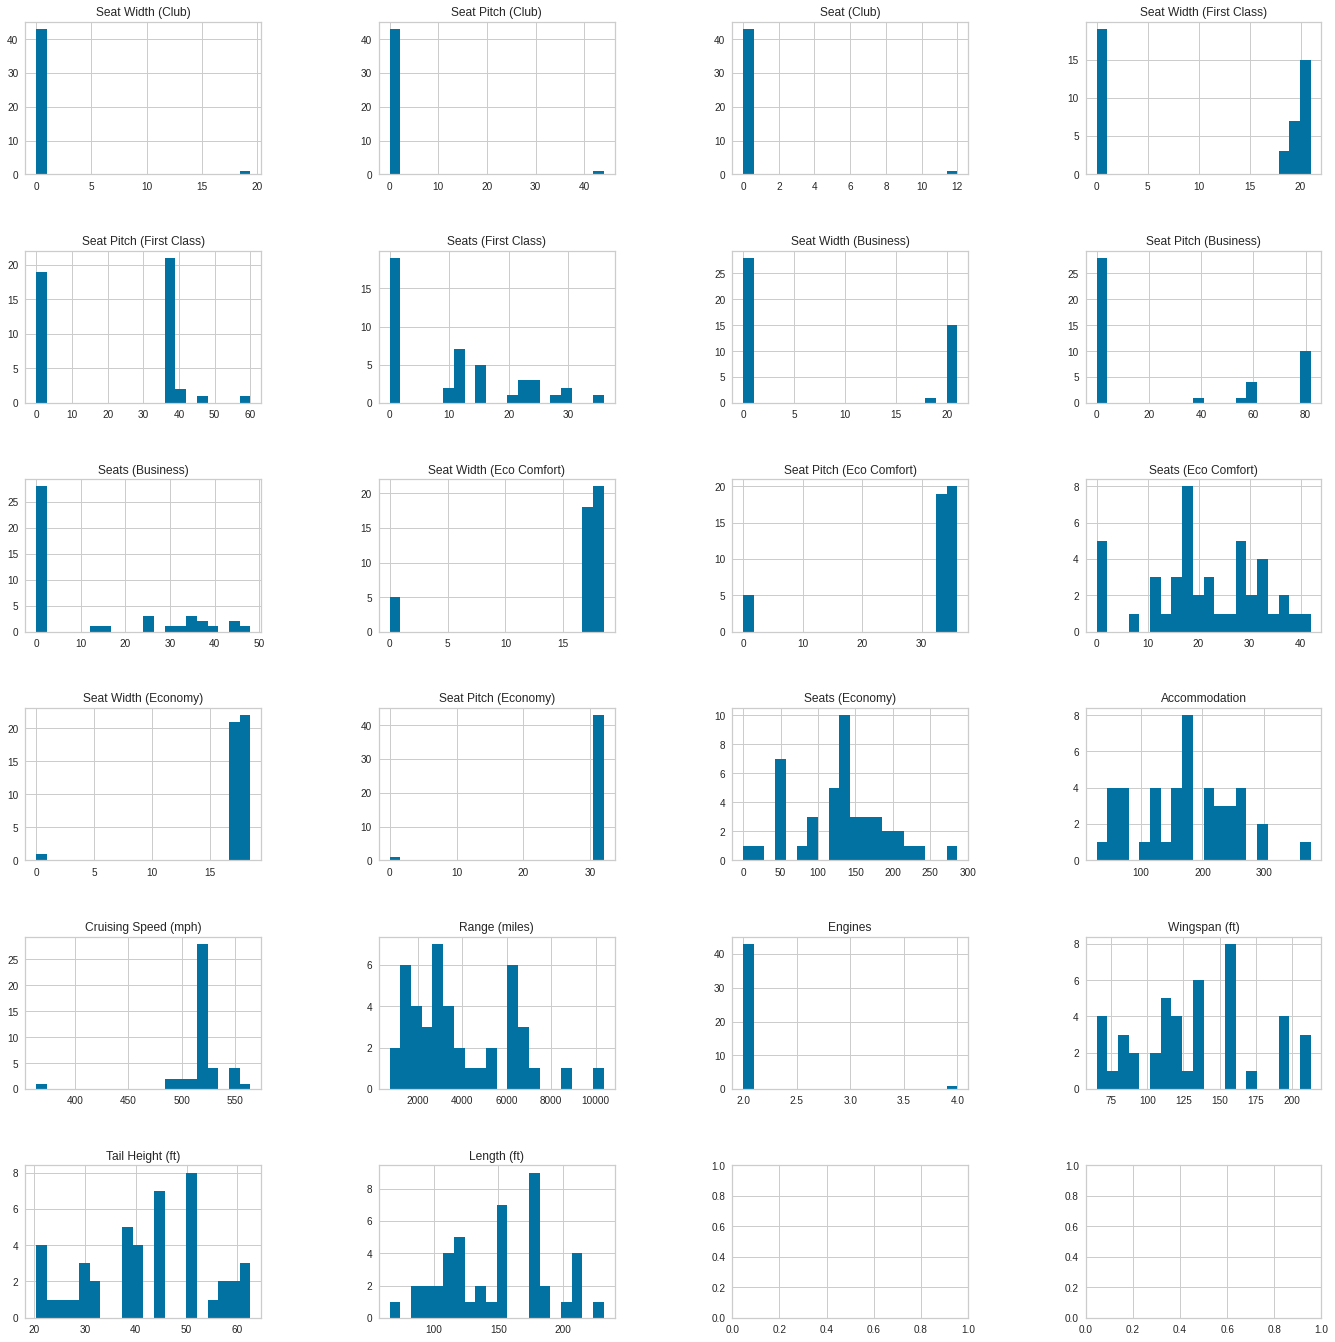

In [304]:
n_cols = plot_df.shape[1]
n_cols_per_row = 4
n_rows = math.ceil(n_cols / n_cols_per_row)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols_per_row, figsize=(20, 20),
                         tight_layout=True, gridspec_kw={'width_ratios': [1] * n_cols_per_row, 'wspace': 0.5, 'hspace': 0.5})

for i, col_name in enumerate(plot_df.columns):
    row = i // n_cols_per_row
    col = i % n_cols_per_row
    ax = axes[row, col]
    ax.hist(plot_df[col_name], bins=20)
    ax.set_title(col_name)

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.5, hspace=0.5)

The distributions are not gaussian, and the range of values from feature to feature can be quite large. For instance, 'Range (miles)' range between ~ 2000 to 10,000, while 'Engines' can only take values between 2 and 4. Therefore, we need to scale the features. We will use the `MinMaxScaler` to scale the features to a range between zero and one.

### PCA

Note, we only apply scaling to non-indicator variables. It does not make sense to apply scaling to 0-1 variables.

In [174]:
# Pipeline
pipeline_delta_pca = Pipeline([
    ('non_dummy_transformer', ColumnTransformer([
        ('scaler', MinMaxScaler(), plot_df.columns.tolist())
    ], remainder = 'passthrough')), 
    ('pca', PCA(n_components=33, whiten=True))
])

# Fit
pipeline_delta_pca.fit(delta)

Pipeline(steps=[('non_dummy_transformer', ColumnTransformer()), ('pca', PCA())])

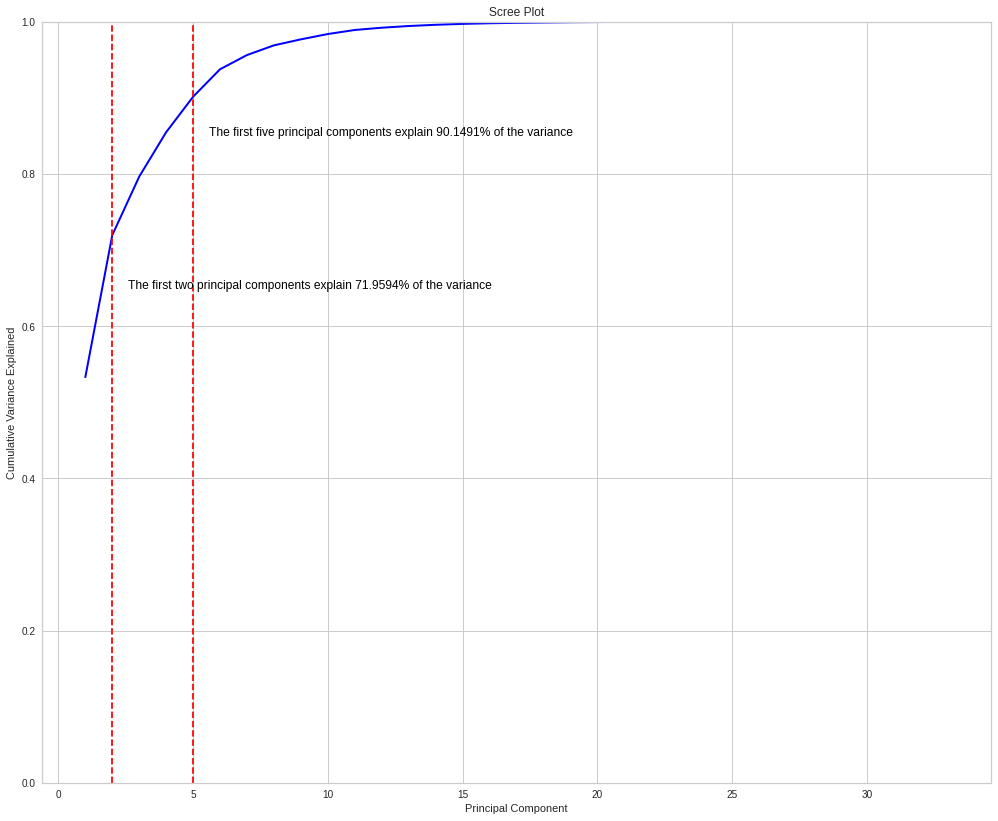

In [182]:
# Cumulative explained variance
cum_exp_var = np.cumsum(pipeline_delta_pca['pca'].explained_variance_ratio_.to_numpy())
# Number of principle components to explain > 90% variance
num_pc_90 = np.min(np.argwhere(cum_exp_var > 0.9)) + 1

# Plot scree plot for pca   
plt.plot(np.arange(pipeline_delta_pca['pca']._n_components) + 1, cum_exp_var, linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')

plt.axvline(x=num_pc_90, color='red', linestyle='--')
plt.text(num_pc_90 + 0.6, 0.85, f'The first five principal components explain {round(cum_exp_var[4] * 100, 4)}% of the variance', color='black')

plt.axvline(x=2, color='red', linestyle='--')
plt.text(2 + 0.6, 0.65, f'The first two principal components explain {round(cum_exp_var[1] * 100, 4)}% of the variance', color='black')

plt.ylim(0, 1.0)
plt.ylabel('Cumulative Variance Explained')
plt.show();

If we plot the data on the two-dimensional x-y plane, then we have the following:

In [178]:
first_two_pcs = pipeline_delta_pca.transform(delta).iloc[:, :2]
first_two_pcs['aircraft'] = delta.index.to_numpy()
first_two_pcs.head(5)

,0,1,aircraft
0,-0.942826,0.088018,Airbus A319
1,-0.318696,-1.200134,Airbus A319 VIP
2,-0.923309,0.129822,Airbus A320
3,-0.923309,0.129822,Airbus A320 32-R
4,1.382857,0.016256,Airbus A330-200


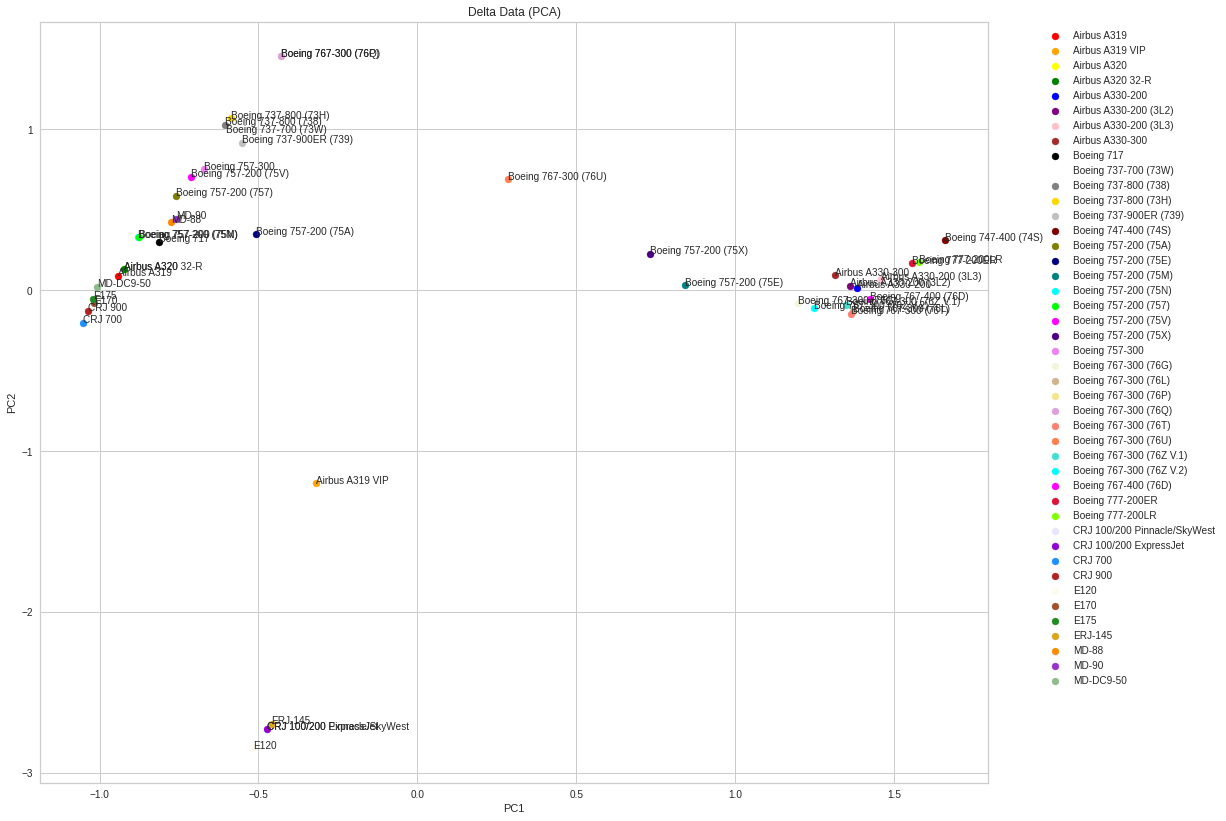

In [302]:
# Data for plotting
x_delta_pca = first_two_pcs.iloc[:, 0].to_numpy()
y_delta_pca = first_two_pcs.iloc[:, 1].to_numpy()
aircrafts_pca = first_two_pcs['aircraft'].to_numpy()

# Define a color map and markers for each cluster
colors = ["red", "orange", "yellow", "green", "blue", "purple", "pink", "brown", "black", "white", "gray", "gold", "silver", "maroon", 
          "olive", "navy", "teal", "aqua", "lime", "fuchsia", "indigo", "violet", "beige", "tan", "khaki", "plum", "salmon", "coral", 
          "turquoise", "cyan", "magenta", "crimson", "chartreuse", "lavender", "darkviolet", "dodgerblue", "firebrick", "floralwhite", "sienna", 
          "forestgreen", "goldenrod", "darkorange", "darkorchid", "darkseagreen"]

# Create the scatter plot
fig, ax = plt.subplots()
for i, c in np.ndenumerate(np.unique(first_two_pcs['aircraft'].to_numpy())):
    mask = first_two_pcs['aircraft'].to_numpy() == c
    ax.scatter(x_delta_pca[mask], y_delta_pca[mask], c=colors[i[0]]) # The index i is a tuple (i, ) so we extract the integer
    for x, y, label in zip(x_delta_pca[mask], y_delta_pca[mask], aircrafts_pca[mask]): # Iterate over all points and aircraft labels
      ax.text(x, y, label, fontsize=10)
    
# Add axis labels and show the plot
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Delta Data (PCA)')
plt.legend([first_two_pcs['aircraft'].iloc[i] for i in range(44)], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show();

Note that the first two principal compoents capture ~ $71.96\%$ of the covariation structure of the original data matrix. Using only the first two principal components, which are linear combinations of the original features, means that we lose some information from the original data.

### T-SNE

First, we scale the non-indicator variables using the `MaxMinScaler`. We do this once so the hyperparameter tuning does not need re-scaling every trial.

In [186]:
delta_scaled = ColumnTransformer([('scaler', MinMaxScaler(), plot_df.columns.tolist())], remainder = 'passthrough').fit_transform(delta)
delta_scaled.shape

(44, 33)

In [187]:
delta_scaled.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,0.0,0.0,0.0,1.00000,0.600000,0.333333,0.0,0.000000,0.000000,0.929730,0.944444,0.428571,0.929730,0.953125,0.335664,0.281609,0.765,0.172957,0.0,0.316807,0.431258,0.273190,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
1,1.0,1.0,1.0,0.92381,0.666667,0.777778,1.0,0.719512,0.291667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.074713,0.765,0.247615,0.0,0.316807,0.431258,0.273190,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.00000,0.600000,0.333333,0.0,0.000000,0.000000,0.929730,0.944444,0.428571,0.929730,0.984375,0.419580,0.350575,0.765,0.175135,0.0,0.316807,0.431258,0.346875,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
3,0.0,0.0,0.0,1.00000,0.600000,0.333333,0.0,0.000000,0.000000,0.929730,0.944444,0.428571,0.929730,0.984375,0.419580,0.350575,0.765,0.175135,0.0,0.316807,0.431258,0.346875,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
4,0.0,0.0,0.0,0.00000,0.000000,0.000000,1.0,0.731707,0.666667,0.972973,0.972222,0.714286,0.972973,0.953125,0.632867,0.617816,0.835,0.601929,0.0,0.897558,0.935631,0.740386,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0


Define an objective function to minimze the KL-divergence for different combinations of T-SNE parameters:

In [212]:
def objective(trial):

  search_space = {
      'perplexity': trial.suggest_categorical('perplexity', [5, 6, 7, 8, 9, 10]),
      'learning_rate': trial.suggest_float(name='learning_rate', low=200, high=600),
      'metric': trial.suggest_categorical('metric', ['l1', 'cityblock', 'manhattan', 'euclidean', 'l2', 'sqeuclidean', 'minkowski', 'chebyshev', 'cosine', 'correlation'])
  }

  # Initialize container
  kl_divergence = np.zeros(5)
  for i in range(5):
    kl_div = TSNE(
        n_components=2,
        perplexity=search_space['perplexity'],
        learning_rate=search_space['learning_rate'],
        metric=search_space['metric'],
        method='fft',
        learning_rate_method='adaptive'
    ).fit(delta_scaled).kl_divergence_

    kl_divergence[i] = kl_div

  min_kl = kl_divergence.min()

  return min_kl

In [306]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(), study_name='minimize_kl_divergence', direction='minimize')
study.optimize(objective, n_trials=10)

[I 2023-01-24 05:24:30,684] A new study created in memory with name: minimize_kl_divergence
[I 2023-01-24 05:24:33,434] Trial 0 finished with value: 0.3956306576728821 and parameters: {'perplexity': 7, 'learning_rate': 292.2225052698068, 'metric': 'minkowski'}. Best is trial 0 with value: 0.3956306576728821.
[I 2023-01-24 05:24:35,548] Trial 1 finished with value: 0.38736918568611145 and parameters: {'perplexity': 6, 'learning_rate': 585.9905368768286, 'metric': 'minkowski'}. Best is trial 1 with value: 0.38736918568611145.
[I 2023-01-24 05:24:37,687] Trial 2 finished with value: 0.5248874425888062 and parameters: {'perplexity': 9, 'learning_rate': 433.66865000612137, 'metric': 'manhattan'}. Best is trial 1 with value: 0.38736918568611145.
[I 2023-01-24 05:24:39,806] Trial 3 finished with value: 0.3816877007484436 and parameters: {'perplexity': 6, 'learning_rate': 220.8848159987275, 'metric': 'minkowski'}. Best is trial 3 with value: 0.3816877007484436.
[I 2023-01-24 05:24:41,926] Tria

The set of parameters yielded the lowest KL-divergence, over five runs of T-SNE, is as follow:

In [307]:
study.best_params

{'perplexity': 5, 'learning_rate': 509.44695450087016, 'metric': 'euclidean'}

Finally, apply the T-SNE technique to the data using the set of parameters chosen above:

In [308]:
delta_tsne = TSNE(n_components=2, method='fft', **study.best_params).fit_transform(delta_scaled)
delta_tsne.shape

(44, 2)

In [309]:
delta_tsne['aircraft'] = delta.index.to_numpy()
delta_tsne.head(5)

,0,1,aircraft
0,19.750469,-6.570122,Airbus A319
1,5.536124,12.851407,Airbus A319 VIP
2,16.887846,-6.821156,Airbus A320
3,17.884226,-4.433572,Airbus A320 32-R
4,-21.539110,21.669258,Airbus A330-200


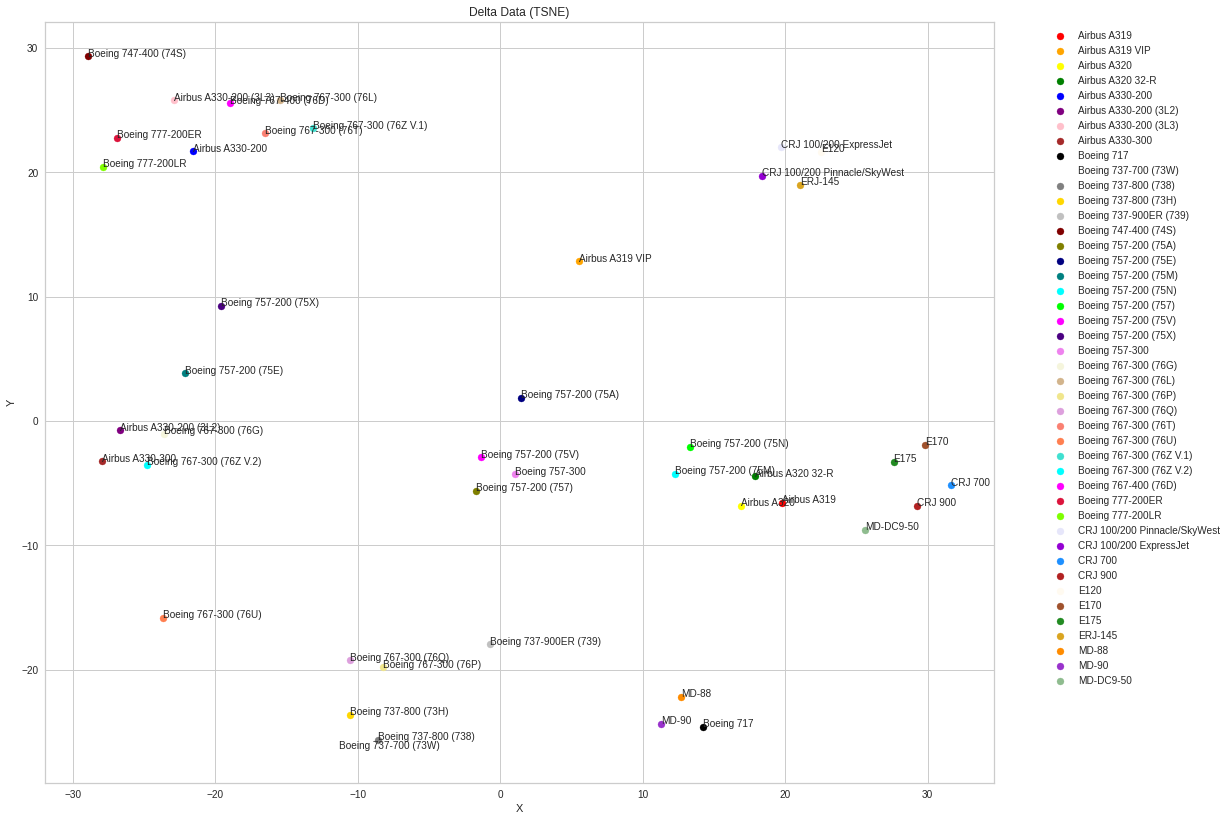

In [310]:
# Data for plotting
x_delta_tsne = delta_tsne.iloc[:, 0].to_numpy()
y_delta_tsne = delta_tsne.iloc[:, 1].to_numpy()
aircrafts_tsne = delta_tsne['aircraft'].to_numpy()

# Define a color map and markers for each cluster
colors = ["red", "orange", "yellow", "green", "blue", "purple", "pink", "brown", "black", "white", "gray", "gold", "silver", "maroon", 
          "olive", "navy", "teal", "aqua", "lime", "fuchsia", "indigo", "violet", "beige", "tan", "khaki", "plum", "salmon", "coral", 
          "turquoise", "cyan", "magenta", "crimson", "chartreuse", "lavender", "darkviolet", "dodgerblue", "firebrick", "floralwhite", "sienna", 
          "forestgreen", "goldenrod", "darkorange", "darkorchid", "darkseagreen"]

# Create the scatter plot
fig, ax = plt.subplots()
for i, c in np.ndenumerate(np.unique(delta_tsne['aircraft'].to_numpy())):
    mask = delta_tsne['aircraft'].to_numpy() == c
    ax.scatter(x_delta_tsne[mask], y_delta_tsne[mask], c=colors[i[0]]) # The index i is a tuple (i, ) so we extract the integer
    for x, y, label in zip(x_delta_tsne[mask], y_delta_tsne[mask], aircrafts_tsne[mask]):
      ax.text(x, y, label, fontsize=10)
    
# Add axis labels and show the plot
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Delta Data (TSNE)')
plt.legend([delta_tsne['aircraft'].iloc[i] for i in range(44)], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show();

### Observation

The T-SNE plot contains more clusters compared to that of PCA, but this may be the artifects of the T-SNE technique. It is generally the case that T-SNE with random initialization, which is the only method supported by the `cuml` implementation, does not preserve global structure.

Another interesting observation is that there are certainly similar and dissimilar aircrafts, as can be seen from the PCA plot. While PCA and T-SNE may aid in visualization, the clutering algorithms in the other sections of the homework can further tease out these interesting patterns.

# Problem 5

## Agglomerative Clustering 

In [313]:
delta_scaled_np = delta_scaled.to_numpy()
delta_scaled_np.shape

(44, 33)

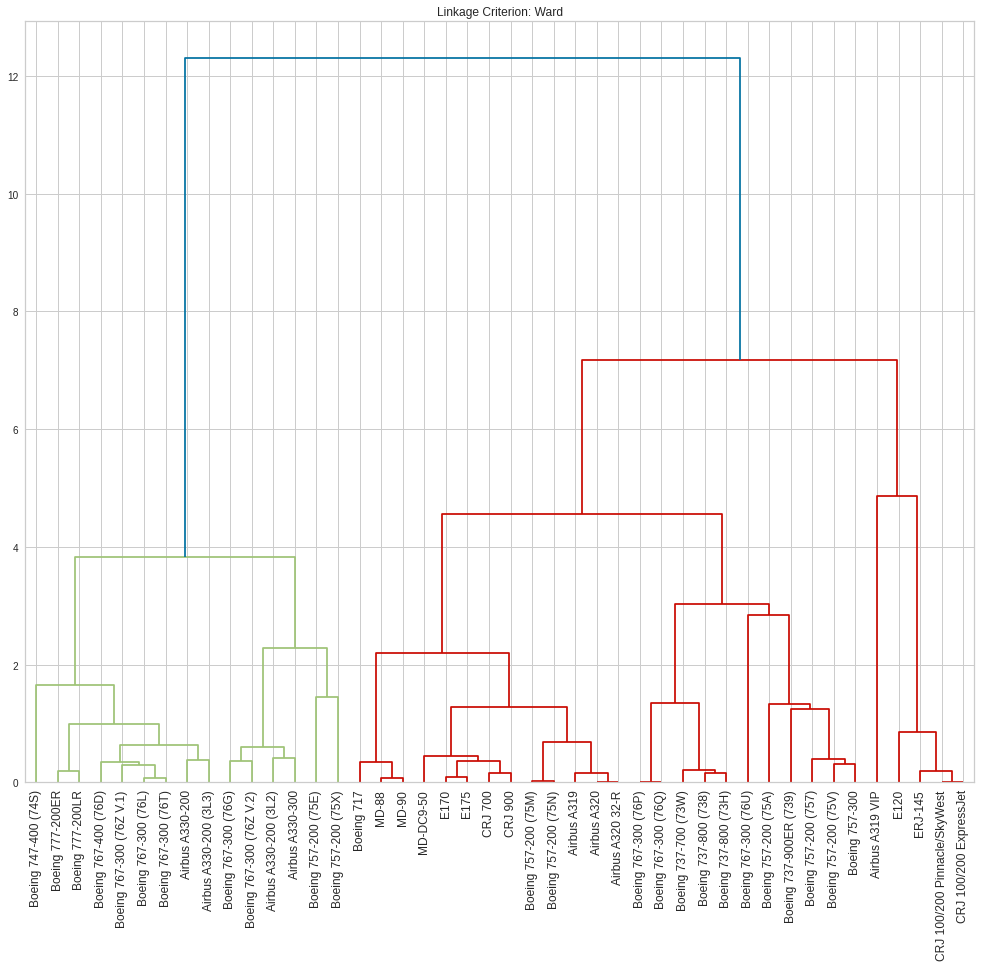

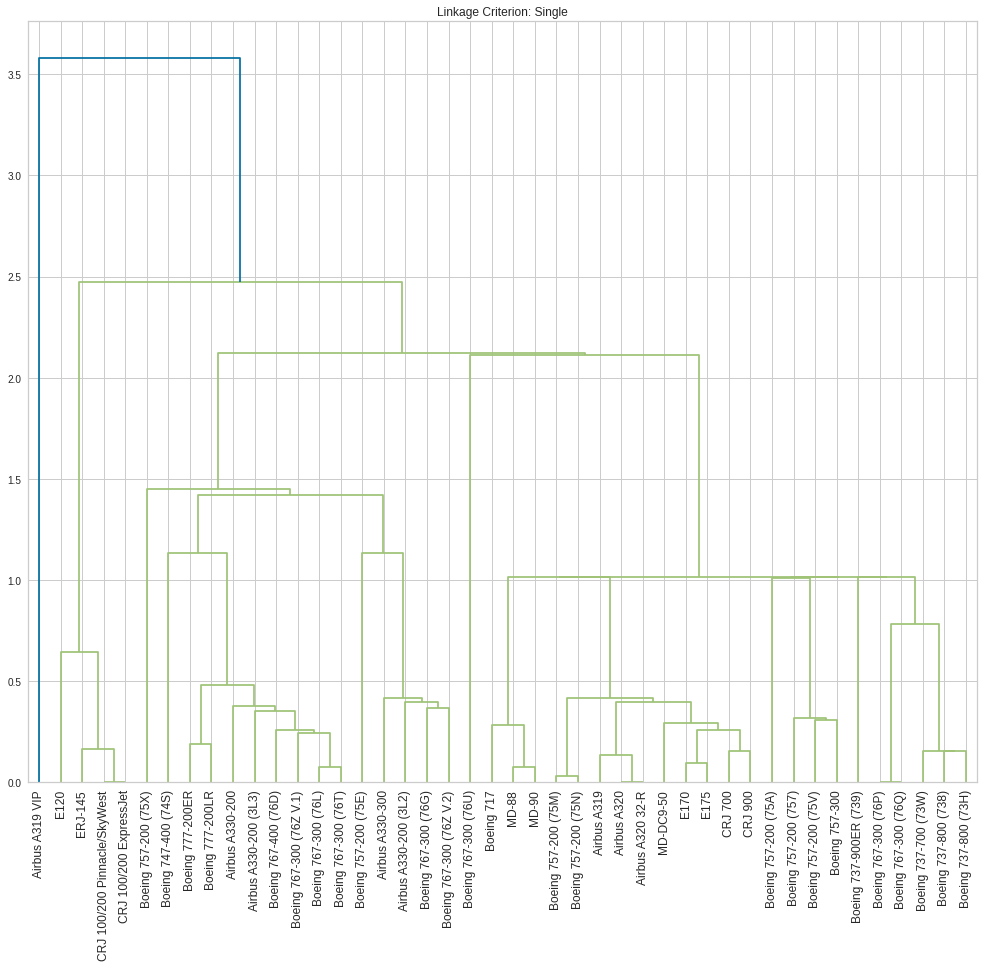

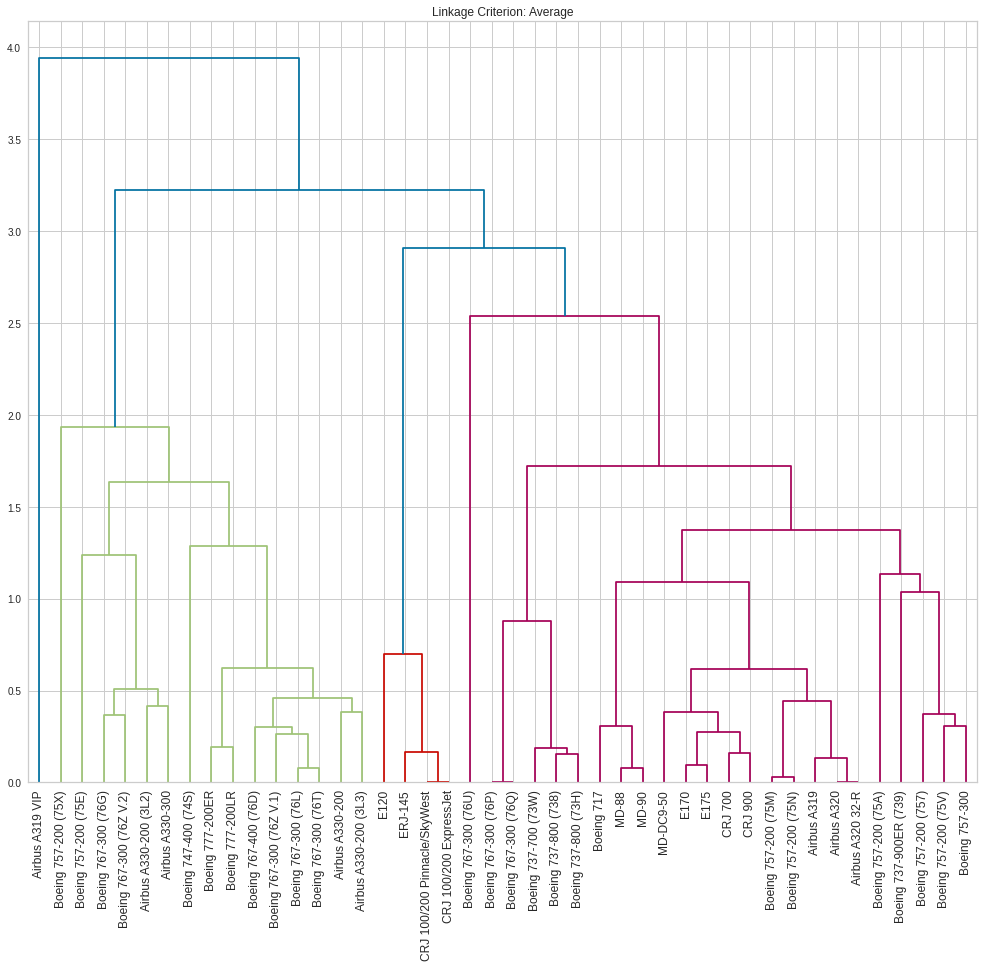

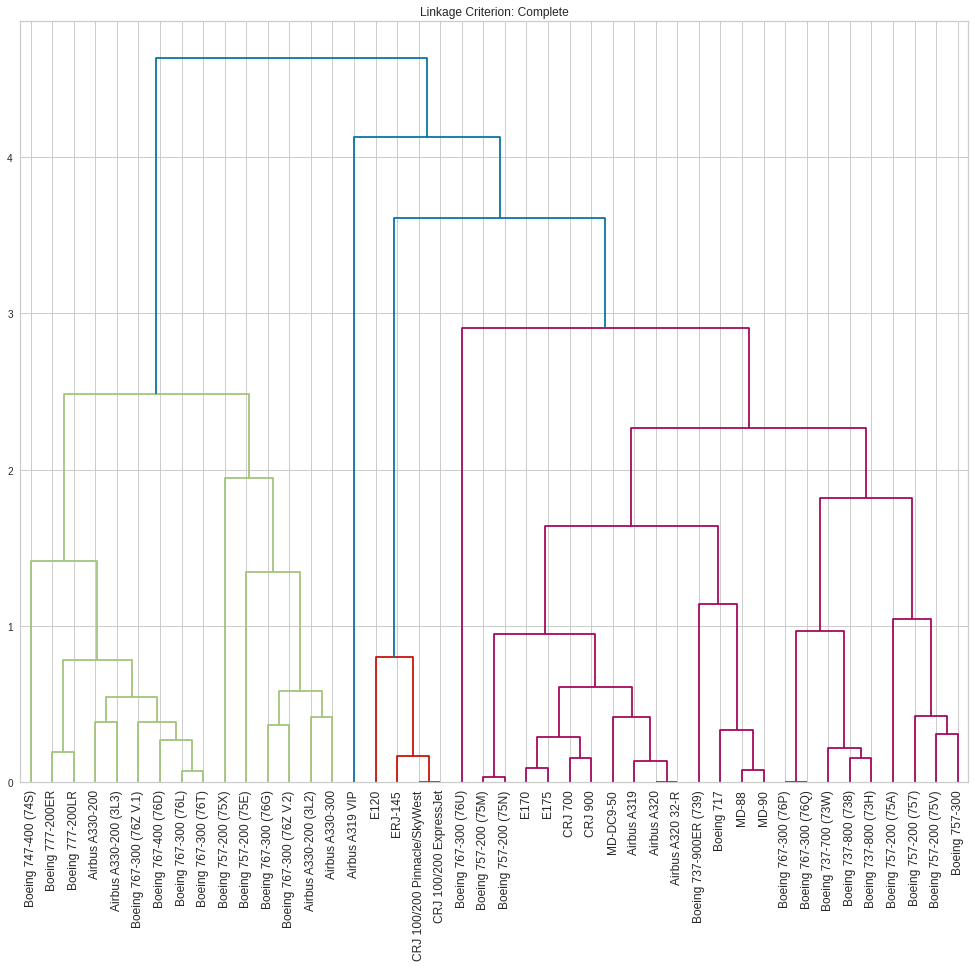

In [319]:
for criterion in ['ward', 'single', 'average', 'complete']:
  mergings = linkage(delta_scaled_np, method=criterion)
  dendrogram(
      mergings,
      labels=delta.index.to_numpy(),
      leaf_rotation=90.,
      leaf_font_size=12
  )
  plt.title('Linkage Criterion: ' + criterion.capitalize())
  plt.show();

### Observations

In the results, above, single linkage created the least number of clusters while complete and average linkage criteria produced the most number of clusters. These difference may be due to the differences in their linkages:

* Ward minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.

* Maximum or complete linkage minimizes the maximum distance between observations of pairs of clusters.

* Average linkage minimizes the average of the distances between all observations of pairs of clusters.

* Single linkage minimizes the distance between the closest observations of pairs of clusters.

### Complete Linkage

The worst case time complexity of complete-link clustering is at most $O(n^2 log n)$. One $O(n^2 log n)$ algorithm is to compute the $n^2$ distance metric and then sort the distances for each data point (overall time: $O(n^2 log n)$). After each merge iteration, the distance metric can be updated in $O(n)$. We pick the next pair to merge by finding the smallest distance that is still eligible for merging. If we do this by traversing the $n$ sorted lists of distances, then, by the end of clustering, we will have done $n^2$ traversal steps. Adding all this up gives us $O(n^2 log n)$.

### Single Linkage

The time complexity of single-link clustering is $O(n^2)$. We first compute all distances in $O(n^2)$. While doing this we also find the smallest distance for each data point and keep them in a next-best-merge array. In each of the $n-1$ merging steps we then find the smallest distance in the next-best-merge array. We merge the two identified clusters, and update the distance matrix in $O(n)$. Finally, we update the next-best-merge array in $O(n)$ in each step. We can do the latter in $O(n)$ because if the best merge partner for k before merging i and j was either i or j, then after merging i and j the best merge partner for k is the merger of i and j.